<a href="https://colab.research.google.com/github/SoniaPMi/AI-3-PyTorch/blob/main/3_GRU_WeatherDenmark_KERAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![IDAL](https://i.imgur.com/tIKXIG1.jpg)  

#**Máster en Inteligencia Artificial Avanzada y Aplicada:  IA^3**
---


#<strong><center>Prediccion meteorológica multivariante</center></strong>

## Introducción

Este tutorial trata de predecir el tiempo futuro de una ciudad utilizando datos meteorológicos de otras ciudades.

Como trabajaremos con secuencias de longitud arbitraria, utilizaremos una Red Neuronal Recurrente (RNN).

El siguiente mapa muestra la ubicación de las ciudades de Dinamarca:
![Map of Denmark](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/images/Denmark.jpg?raw=1)

El siguiente mapa muestra la ubicación de Dinamarca en Europa:

![Map of Europe](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/images/Europe.jpg?raw=1)

## Diagrama de flujo

En este tutorial, intentaremos predecir el tiempo de la ciudad danesa "Odense" 24 horas en el futuro, dados los datos meteorológicos actuales y pasados de 5 ciudades (aunque el diagrama de flujo de abajo sólo muestra 2 ciudades).

Utilizamos una red neuronal recurrente (RNN) porque puede trabajar con secuencias de longitud arbitraria. Durante el entrenamiento utilizaremos subsecuencias de 1.344 puntos de datos (8 semanas) del conjunto de entrenamiento, y cada punto de datos u observación tendrá 20 señales de entrada para la temperatura, la presión, etc. de cada una de las 5 ciudades. A continuación, queremos entrenar la red neuronal para que emita las 3 señales de temperatura, presión y velocidad del viento de mañana.

![Flowchart](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/images/23_time_series_flowchart.png?raw=1)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

## Cargar datos

A continuación se descargarán automáticamente los datos meteorológicos de 5 ciudades de Dinamarca.

Los datos meteorológicos en bruto se obtuvieron originalmente del [Centro Nacional de Datos Climáticos (NCDC), EE.UU.](https://www7.ncdc.noaa.gov/CDO/cdoselect.cmd). Su sitio web y el acceso a la base de datos son muy confusos y pueden cambiar pronto. Además, el archivo de datos en bruto tuvo que ser editado manualmente antes de poder ser leído. Por lo tanto, si quieres descargar los datos meteorológicos de otra región, deberás enfrentarte a algunos problemas. El siguiente módulo de Python ofrece algunas funcionalidades que pueden ser útiles si quieres utilizar nuevos datos meteorológicos, pero tendrás que modificar el código fuente para adaptarlo a tu formato de datos.

Cargamos los datos del fichero "weather-denmark.csv"
*Recuerda ponerlo disponible para Colab de alguna de las diversas formas posibles. Dado ue es un fichero grande es mejor conectar con Drive*

In [4]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/weather-denmark.csv'
na_values = ['999', '999.0', '999.9', '9999.9']
df = pd.read_csv(path, sep=',', header=0, index_col=False, na_values=na_values)

In [12]:
na_values = ['999', '999.0', '999.9', '9999.9']

df = pd.read_csv('/content/sample_data/weather-denmark.csv', index_col=False, na_values=na_values)
len(df)




2918150

In [13]:
df.head()

,City,DateTime,Temp,Pressure,WindSpeed,WindDir
0,Aalborg,1980-03-01 00:00:00,5.0,1008.1,11.3,290.0
1,Aalborg,1980-03-01 00:20:00,4.0,NaN,9.2,270.0
2,Aalborg,1980-03-01 00:50:00,4.0,NaN,9.2,280.0
3,Aalborg,1980-03-01 01:20:00,4.0,NaN,9.2,280.0
4,Aalborg,1980-03-01 01:50:00,4.0,NaN,8.7,270.0


In [14]:
df.shape

(2918150, 6)

Lista de ciudades

In [15]:
cities = df['City'].unique()
cities

array(['Aalborg', 'Aarhus', 'Esbjerg', 'Odense', 'Roskilde'], dtype=object)

In [16]:
df.dtypes

City          object
DateTime      object
Temp         float64
Pressure     float64
WindSpeed    float64
WindDir      float64
dtype: object

In [17]:
# Mas preproceso 
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d %H:%M:%S')

In [18]:
df.dtypes

City                 object
DateTime     datetime64[ns]
Temp                float64
Pressure            float64
WindSpeed           float64
WindDir             float64
dtype: object

Cargue y remuestree los datos para que tenga observaciones en intervalos de tiempo regulares por cada 60 minutos. Los puntos de datos que faltan se interpolan linealmente. La primera vez tarda unos 30 segundos en ejecutarse, pero utiliza un archivo de caché para que se cargue muy rápidamente la próxima vez.

In [19]:
# Pongo city-name y date-time como indices.
df.set_index(['City', 'DateTime'], inplace=True)

In [20]:
df.shape

(2918150, 4)

In [21]:
df.head()

Temp  Pressure  WindSpeed  WindDir
City    DateTime                                               
Aalborg 1980-03-01 00:00:00   5.0    1008.1       11.3    290.0
        1980-03-01 00:20:00   4.0       NaN        9.2    270.0
        1980-03-01 00:50:00   4.0       NaN        9.2    280.0
        1980-03-01 01:20:00   4.0       NaN        9.2    280.0
        1980-03-01 01:50:00   4.0       NaN        8.7    270.0

In [22]:
df_cities = [df.xs(city) for city in cities]   
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.xs.html

In [23]:
df_cities

[                     Temp  Pressure  WindSpeed  WindDir
 DateTime                                               
 1980-03-01 00:00:00   5.0    1008.1       11.3    290.0
 1980-03-01 00:20:00   4.0       NaN        9.2    270.0
 1980-03-01 00:50:00   4.0       NaN        9.2    280.0
 1980-03-01 01:20:00   4.0       NaN        9.2    280.0
 1980-03-01 01:50:00   4.0       NaN        8.7    270.0
 ...                   ...       ...        ...      ...
 2018-03-01 22:50:00  -4.0       NaN        7.2     70.0
 2018-03-01 23:00:00  -4.2    1022.5        7.2     70.0
 2018-03-01 23:04:00  -4.0       NaN        6.7     70.0
 2018-03-01 23:21:00  -4.0       NaN        6.7     70.0
 2018-03-01 23:50:00  -4.0       NaN        6.2     70.0
 
 [759897 rows x 4 columns],
                      Temp  Pressure  WindSpeed  WindDir
 DateTime                                               
 1980-03-01 00:00:00   3.0    1008.9        6.2    260.0
 1980-03-01 01:00:00   3.0       NaN        7.2    260.0
 

In [24]:
def resample(df):
    """
    Remuestrear el contenido de dataframe de Pandas, primero
    eliminando las filas y columnas vacías, luego muestreando y
    interpolando los datos en intervalos de 1 minuto, y
    por último, reduciendo el muestreo a intervalos de 60 minutos.
    """

    # Remove all empty rows.
    df_res = df.dropna(how='all')

    # Upsample so the time-series has data for every minute.
    # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html?highlight=resample#pandas.DataFrame.resample
    df_res = df_res.resample('1T')

    # Fill in missing values.
    df_res = df_res.interpolate(method='time')

    # Downsample so the time-series has data for every hour.
    df_res = df_res.resample('60T')

    # Finalize the resampling. (Is this really necessary?)
    df_res = df_res.interpolate()

    # Remove all empty rows.
    df_res = df_res.dropna(how='all')

    return df_res



In [25]:
%%time
df_resampled = [resample(df_city) for df_city in df_cities]

# Join the resampled data into a single data-frame.
df = pd.concat(df_resampled, keys=cities, axis=1, join='inner')

CPU times: user 1min 59s, sys: 10.3 s, total: 2min 10s
Wall time: 2min 9s


In [26]:
df.head()

Aalborg               ...   Roskilde            
                         Temp     Pressure  ...  WindSpeed     WindDir
DateTime                                    ...                       
1980-03-01 11:00:00  5.000000  1007.766667  ...  11.466667  280.000000
1980-03-01 12:00:00  5.000000  1008.000000  ...  12.466667  280.000000
1980-03-01 13:00:00  5.000000  1008.066667  ...  13.133333  278.333333
1980-03-01 14:00:00  4.333333  1008.133333  ...  12.300000  270.000000
1980-03-01 15:00:00  4.000000  1008.200000  ...  12.300000  270.000000

[5 rows x 20 columns]

### Datos que faltan

En las dos ciudades de Esbjerg y Roskilde faltan datos sobre la presión atmosférica, como puede verse en los dos gráficos siguientes. 

Como estamos utilizando datos remuestreados, hemos rellenado los valores que faltan con nuevos valores interpolados linealmente a partir de los valores vecinos, que aparecen como largas líneas rectas en estos gráficos.

Esto puede confundir a la red neuronal. Para simplificar, simplemente eliminaremos estas dos señales de los datos.

Pero sólo faltan períodos cortos de datos, por lo que podría generar estos datos creando un modelo predictivo que genere los datos que faltan a partir de todas las demás señales de entrada. A continuación, se podrían añadir estos valores generados al conjunto de datos para rellenar los huecos.

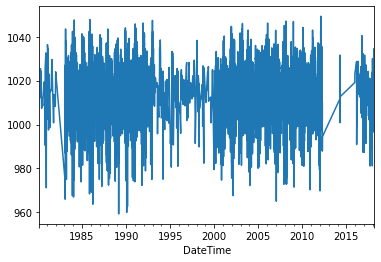

In [27]:
df['Esbjerg']['Pressure'].plot();

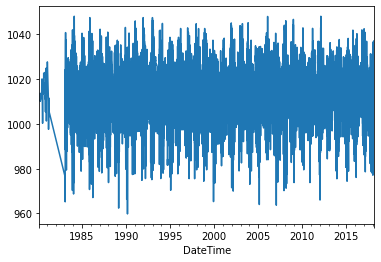

In [28]:
df['Roskilde']['Pressure'].plot();

Antes de eliminar estas dos señales, hay 20 señales de entrada en el conjunto de datos.

In [29]:
df.values.shape

(333109, 20)

Ahora eliminamos las dos señales (columnas) que tienen datos faltantes.

In [30]:
df.drop(('Esbjerg', 'Pressure'), axis=1, inplace=True)
df.drop(('Roskilde', 'Pressure'), axis=1, inplace=True)

En el conjunto de datos ahora hay solo 18 señales de entrada.

In [31]:
df.values.shape

(333109, 18)

We can verify that these two data-columns have indeed been removed.

In [32]:
df.head(1)

Aalborg                         ... Roskilde                   
                       Temp     Pressure WindSpeed  ...     Temp  WindSpeed WindDir
DateTime                                            ...                            
1980-03-01 11:00:00     5.0  1007.766667      10.2  ...      5.0  11.466667   280.0

[1 rows x 18 columns]

### Errores en los datos

Hay algunos errores en estos datos. Como se muestra en el gráfico de abajo, la temperatura en la ciudad de Odense saltó de repente a casi 50 grados C. Pero la temperatura más alta jamás medida en Dinamarca fue sólo de 36,4 grados Celsius y la más baja fue de -31,2 C. Así que esto es claramente un error de datos. Sin embargo, en este tutorial no corregiremos ningún error de datos.

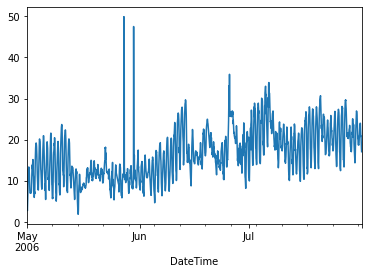

In [33]:
df['Odense']['Temp']['2006-05':'2006-07'].plot();

También se puede confirmar que se trata de un error si se tienen en cuenta las temperaturas de otras ciudades de Dinamarca en ese periodo, que sólo fueron de unos 10 grados. Como el país es tan pequeño, no es posible que una ciudad de Dinamarca tenga 50 grados y otra sólo 10.

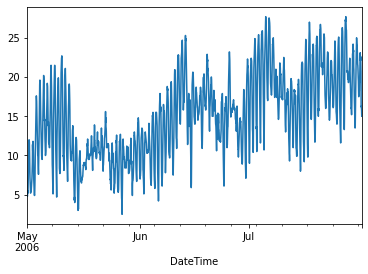

In [34]:
df['Aarhus']['Temp']['2006-05':'2006-07'].plot();

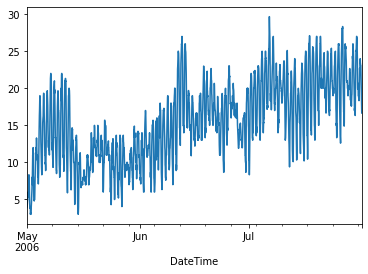

In [35]:
df['Roskilde']['Temp']['2006-05':'2006-07'].plot();

### Adición de datos

Podemos añadir algunas señales de entrada a los datos que pueden ayudar a nuestro modelo a hacer predicciones.

Por ejemplo, dada una temperatura de 10 grados Celsius, el modelo no sabría si esa temperatura se midió durante el día o la noche, o durante el verano o el invierno. El modelo tendría que deducirlo de los puntos de datos circundantes, lo que podría no ser muy preciso para determinar si se trata de un invierno anormalmente cálido o de un verano anormalmente frío, o si es de día o de noche. Por tanto, disponer de esta información podría suponer una gran diferencia en la precisión con la que el modelo puede predecir el siguiente resultado.

Aunque el conjunto de datos contiene la información sobre la fecha y la hora de cada observación, sólo se utiliza en el índice para ordenar los datos. Por lo tanto, añadiremos señales de entrada separadas al conjunto de datos para el día del año (entre 1 y 366) y la hora del día (entre 0 y 23).

In [36]:
df['Various', 'Day'] = df.index.dayofyear
df['Various', 'Hour'] = df.index.hour

In [37]:
df.head(1)

Aalborg                         ... Roskilde Various     
                       Temp     Pressure WindSpeed  ...  WindDir     Day Hour
DateTime                                            ...                      
1980-03-01 11:00:00     5.0  1007.766667      10.2  ...    280.0      61   11

[1 rows x 20 columns]

### Datos objetivo para la predicción

Intentaremos predecir los datos meteorológicos futuros de esta ciudad.

In [38]:
target_city = 'Odense'

Intentaremos predecir estas señales.

In [39]:
target_names = ['Temp', 'WindSpeed', 'Pressure']

A continuación se indica el número de pasos de tiempo en que desplazaremos los datos-objetivo. Nuestro conjunto de datos está remuestreado para tener una observación por cada hora, por lo que hay 24 observaciones para 24 horas.

Si queremos predecir el tiempo 24 horas en el futuro, desplazamos los datos 24 pasos de tiempo. Si queremos predecir el tiempo de 7 días en el futuro, desplazamos los datos 7 * 24 pasos de tiempo.

In [40]:
shift_days = 1
shift_steps = shift_days * 24  # Number of hours.

Cree un nuevo marco de datos con los datos desplazados en el tiempo.

**Observe el cambio de tiempo negativo.


In [41]:
df_targets = df[target_city][target_names].shift(-shift_steps)

**¡AVISO!** ¡Debe comprobar que ha desplazado los datos en la dirección correcta! Queremos predecir el futuro, no el pasado.

El dataframe desplazado es confuso porque Pandas mantiene las marcas de tiempo originales aunque hayamos desplazado los datos. Puede comprobar que el cambio de tiempo es correcto comparando los marcos de datos originales y los cambiados.

Esta es la primera fila de "pasos de desplazamiento + 5" del marco de datos original:

In [42]:
df[target_city][target_names].head(shift_steps + 5)

,Temp,WindSpeed,Pressure
DateTime,,,
1980-03-01 11:00:00,6.142857,12.585714,1011.066667
1980-03-01 12:00:00,7.000000,11.300000,1011.200000
1980-03-01 13:00:00,7.000000,12.118182,1011.300000
1980-03-01 14:00:00,6.857143,12.742857,1011.400000
1980-03-01 15:00:00,6.000000,12.400000,1011.500000
1980-03-01 16:00:00,4.909091,12.618182,1011.688889
1980-03-01 17:00:00,3.953488,12.646512,1011.877778
1980-03-01 18:00:00,3.674419,11.725581,1012.066667
1980-03-01 19:00:00,3.395349,10.804651,1012.255556


A continuación se muestran las 5 primeras filas de la trama de datos desplazada en el tiempo. Esto debería ser idéntico a las últimas 5 filas mostradas arriba de los datos originales, excepto por la marca de tiempo.

In [43]:
df_targets.head(5)

,Temp,WindSpeed,Pressure
DateTime,,,
1980-03-01 11:00:00,2.000000,6.828571,1005.833333
1980-03-01 12:00:00,2.000000,8.200000,1005.200000
1980-03-01 13:00:00,0.166667,9.216667,1004.766667
1980-03-01 14:00:00,1.000000,11.885714,1004.333333
1980-03-01 15:00:00,1.000000,12.400000,1003.900000


La trama de datos desplazada en el tiempo tiene la misma longitud que la trama de datos original, pero las últimas observaciones son `NaN` (no un número) porque los datos se han desplazado hacia atrás, por lo que estamos intentando desplazar datos que no existen en la trama de datos original.

In [44]:
df_targets.tail()

,Temp,WindSpeed,Pressure
DateTime,,,
2018-03-01 19:00:00,NaN,NaN,NaN
2018-03-01 20:00:00,NaN,NaN,NaN
2018-03-01 21:00:00,NaN,NaN,NaN
2018-03-01 22:00:00,NaN,NaN,NaN
2018-03-01 23:00:00,NaN,NaN,NaN


### NumPy Arrays

Ahora convertimos los dataframes de Pandas en arrays de NumPy que pueden ser introducidos en la red neuronal. También eliminamos la última parte de los arrays de Numpy, porque los datos de destino tienen `Nan` para el período desplazado, y sólo queremos tener datos válidos y necesitamos las mismas formas de array para los datos de entrada y de salida.

Estas son las señales de entrada:

In [45]:
x_data = df.values[0:-shift_steps]

In [46]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (333085, 20)


In [47]:
y_data = df_targets.values[:-shift_steps]

In [48]:
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (333085, 3)


Es el número de observaciones (puntos de datos o muestras) en el conjunto de datos:

In [49]:
num_data = len(x_data)
num_data

333085

In [50]:
train_split = 0.9

In [51]:
num_train = int(train_split * num_data)
num_train

299776

In [52]:
num_test = num_data - num_train
num_test

33309

Estas son las señales de entrada para los conjuntos de entrenamiento y prueba:

In [53]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

333085

Estas son las señales de salida de los conjuntos de entrenamiento y de prueba:


In [54]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

333085

Es el número de señales de entrada:

In [55]:
num_x_signals = x_data.shape[1]
num_x_signals

20

Es el número de señales de salida:

In [56]:
num_y_signals = y_data.shape[1]
num_y_signals

3

### Datos escalados

El conjunto de datos contiene una amplia gama de valores:

In [57]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: -27.0
Max: 1050.8


La red neuronal funciona mejor con valores aproximadamente entre -1 y 1, por lo que tenemos que escalar los datos antes de introducirlos en la red neuronal. Para ello podemos utilizar `scikit-learn`.

Primero creamos un objeto escalador para las señales de entrada.

In [58]:
x_scaler = MinMaxScaler()

A continuación, detectamos el rango de valores de los datos de entrenamiento y escalamos los datos de entrenamiento.

In [59]:
x_train_scaled = x_scaler.fit_transform(x_train)

Aparte de un pequeño error de redondeo, los datos se han escalado para que estén entre 0 y 1.

In [60]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0000000000000002


**Importante:** Utilizamos el mismo objeto escalador para las señales de entrada en el conjunto de pruebas.

In [61]:
x_test_scaled = x_scaler.transform(x_test)

Los datos de destino proceden del mismo conjunto de datos que las señales de entrada, ya que se trata de los datos meteorológicos de una de las ciudades que simplemente están desplazados en el tiempo. Pero los datos de destino podrían ser de una fuente diferente con diferentes rangos de valores, por lo que creamos un objeto escalador separado para los datos de destino.

In [62]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

## Generador de datos

El conjunto de datos ha sido preparado como arrays numpy bidimensionales. Los datos de entrenamiento tienen casi 300k observaciones, que consisten en 20 señales de entrada y 3 señales de salida.

Estas son las formas de array de los datos de entrada y salida:

In [63]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(299776, 20)
(299776, 3)


En lugar de entrenar la Red Neuronal Recurrente en las secuencias completas de casi 300k observaciones, utilizaremos la siguiente función para crear un lote de subsecuencias más cortas escogidas al azar de los datos de entrenamiento.

In [64]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

Utilizaremos un tamaño de lote grande para mantener la GPU cerca del 100% de la carga de trabajo. Es posible que tengas que ajustar este número en función de tu GPU, su memoria RAM y tu elección de `sequence_length` más adelante.



In [65]:
batch_size = 256

Utilizaremos una longitud de secuencia de 1344, lo que significa que cada secuencia aleatoria contiene observaciones para 8 semanas.

 Un paso de tiempo corresponde a una hora, por lo que 24 x 7 pasos de tiempo corresponden a una semana, y 24 x 7 x 8 corresponden a 8 semanas.

In [66]:
sequence_length = 24 * 7 * 8
sequence_length

1344

Creamos el batch-generator.

In [67]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

Probamos el batch-generator.

In [68]:
x_batch, y_batch = next(generator)

Esto nos da un lote aleatorio de 256 secuencias, cada secuencia tiene 1344 observaciones, y cada observación tiene 20 señales de entrada y 3 señales de salida.

In [69]:
print(x_batch.shape)
print(y_batch.shape)

(256, 1344, 20)
(256, 1344, 3)


Podemos graficar alguna de las 20 señales de entrada como ejemplo.

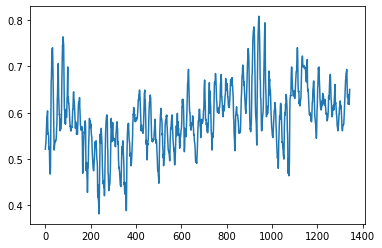

In [70]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

También podemos trazar una de las señales de salida que queremos que el modelo aprenda a predecir dadas las 20 señales de entrada.

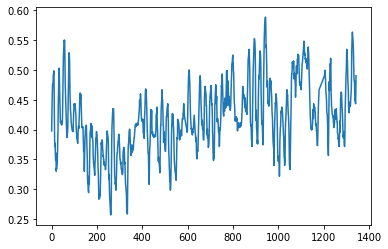

In [71]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

### Conjunto de validación

La red neuronal se entrena rápidamente, por lo que podemos ejecutar fácilmente muchas épocas de entrenamiento. Sin embargo, existe el riesgo de sobreajustar el modelo al conjunto de entrenamiento, por lo que no se generaliza bien a los datos no vistos. Por lo tanto, controlaremos el rendimiento del modelo en el conjunto de pruebas después de cada época y sólo guardaremos los pesos del modelo si el rendimiento mejora en el conjunto de pruebas.

El generador de lotes selecciona aleatoriamente un lote de secuencias cortas de los datos de entrenamiento y lo utiliza durante el entrenamiento. Sin embargo, para los datos de validación, se ejecuta la secuencia completa del conjunto de pruebas y se mide la precisión de la predicción en esa secuencia completa.

In [72]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

## Crear la Red Neuronal Recurrente

Ya estamos listos para crear la Red Neuronal Recurrente (RNN). Para ello utilizaremos la API de Keras por su sencillez. Consulta el Tutorial #03-C para un tutorial sobre Keras y el Tutorial #20 para más información sobre las Redes Neuronales Recurrentes.

In [73]:
model = Sequential()

Ahora podemos añadir una Unidad Recurrente Cerrada (GRU) a la red. Esta tendrá 512 salidas para cada paso de tiempo en la secuencia.

Tenga en cuenta que debido a que esta es la primera capa en el modelo, Keras necesita saber la forma de su entrada, que es un lote de secuencias de longitud arbitraria (indicado por `None`), donde cada observación tiene un número de señales de entrada (`num_x_signals`).

In [74]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

La GRU produce un lote de secuencias de 512 valores. Queremos predecir 3 señales de salida, así que añadimos una capa totalmente conectada (o densa) que reduce los 512 valores a sólo 3 valores.

Las señales de salida en el conjunto de datos se han limitado a estar entre 0 y 1 utilizando un objeto escalador. Así que también limitamos la salida de la red neuronal utilizando la función de activación Sigmoide, que aplasta la salida para que esté entre 0 y 1.

In [75]:
model.add(Dense(num_y_signals, activation='sigmoid'))

El problema de utilizar la función de activación sigmoidea es que ahora sólo podemos obtener valores en el mismo rango que los datos de entrenamiento.

Por ejemplo, si los datos de entrenamiento sólo tienen temperaturas entre -20 y +30 grados, entonces el objeto escalador asignará -20 a 0 y +30 a 1. Así que si limitamos la salida de la red neuronal a estar entre 0 y 1 usando la función Sigmoide, esto sólo puede ser mapeado de nuevo a valores de temperatura entre -20 y +30.

En cambio, podemos utilizar una función de activación lineal en la salida. Esto permite que la salida tome valores arbitrarios. Puede funcionar con la inicialización estándar para una arquitectura de red simple, pero para arquitecturas de red más complicadas, por ejemplo, con más capas, puede ser necesario inicializar los pesos con valores más pequeños para evitar valores `NaN` durante el entrenamiento. Puede que tengas que experimentar con esto para que funcione.

In [76]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

### Función de pérdida

Utilizaremos el error cuadrático medio (MSE) como la función de pérdida que se minimizará. Esta función mide el grado de coincidencia entre la salida del modelo y las señales de salida reales.

Sin embargo, al principio de una secuencia, el modelo sólo ha visto las señales de entrada durante unos pocos pasos de tiempo, por lo que su salida generada puede ser muy inexacta. El uso del valor de pérdida para los primeros pasos de tiempo puede hacer que el modelo distorsione su salida posterior. Por lo tanto, damos al modelo un "período de calentamiento" de 50 pasos de tiempo en el que no utilizamos su precisión en la función de pérdida, con la esperanza de mejorar la precisión para los pasos de tiempo posteriores.

In [77]:
warmup_steps = 50

In [78]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

### Modelo de compilación

Este es el optimizador y la tasa de aprendizaje inicial que utilizaremos.

In [79]:
optimizer = RMSprop(lr=1e-3)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [80]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

Este es un modelo muy pequeño con sólo dos capas. La forma de salida de `(None, None, 3)` significa que el modelo dará salida a un lote con un número arbitrario de secuencias, cada una de las cuales tiene un número arbitrario de observaciones, y cada observación tiene 3 señales. Esto corresponde a las 3 señales objetivo que queremos predecir.

In [81]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 512)         820224    
                                                                 
 dense (Dense)               (None, None, 3)           1539      
                                                                 
Total params: 821,763
Trainable params: 821,763
Non-trainable params: 0
_________________________________________________________________


### Funciones Callback

Durante el entrenamiento queremos guardar los puntos de control y registrar el progreso en TensorBoard por lo que creamos los callbacks apropiados para Keras.

Este es el callback para escribir los puntos de control durante el entrenamiento.

In [82]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [83]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [84]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

Esta llamada de retorno reduce la tasa de aprendizaje del optimizador si la pérdida de validación no ha mejorado desde la última época (indicada por `patience=0`). La tasa de aprendizaje se reducirá multiplicándola por el factor dado. Hemos establecido una tasa de aprendizaje inicial de 1e-3, por lo que al multiplicarla por 0,1 se obtiene una tasa de aprendizaje de 1e-4. No queremos que la tasa de aprendizaje sea menor que esto.

In [85]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [86]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

## Entrenar la red neuronal recurrente

Ahora podemos entrenar la red neuronal.

Tenga en cuenta que una única "época" no corresponde a un único procesamiento del conjunto de entrenamiento, debido a la forma en que el generador de lotes selecciona aleatoriamente las subsecuencias del conjunto de entrenamiento. En su lugar, hemos seleccionado `pasos_por_época` para que una "época" se procese en unos minutos.

Con esta configuración, cada "epoch" tardó unos 2,5 minutos en procesarse en una GTX 1070. Después de 14 "epochs" la optimización se detuvo porque la pérdida de validación no había disminuido durante 5 "epochs". Esta optimización tardó unos 35 minutos en terminar.

También hay que tener en cuenta que la pérdida a veces se convierte en `NaN` (not-a-number). Esto suele resolverse reiniciando y ejecutando de nuevo el Notebook. Pero también puede ser causado por la arquitectura de su red neuronal, la tasa de aprendizaje, el tamaño del lote, la longitud de la secuencia, etc., en cuyo caso es posible que tenga que modificar esos ajustes.

In [87]:
%%time
model.fit(x=generator,
          epochs=5,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/5
100/100 [==============================] - ETA: 0s - loss: 0.0083
Epoch 00001: val_loss improved from inf to 0.00464, saving model to 23_checkpoint.keras
100/100 [==============================] - 202s 2s/step - loss: 0.0083 - val_loss: 0.0046 - lr: 0.0010
Epoch 2/5
100/100 [==============================] - ETA: 0s - loss: 0.0049
Epoch 00002: val_loss improved from 0.00464 to 0.00346, saving model to 23_checkpoint.keras
100/100 [==============================] - 197s 2s/step - loss: 0.0049 - val_loss: 0.0035 - lr: 0.0010
Epoch 3/5
100/100 [==============================] - ETA: 0s - loss: 0.0040
Epoch 00003: val_loss did not improve from 0.00346

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 197s 2s/step - loss: 0.0040 - val_loss: 0.0047 - lr: 0.0010
Epoch 4/5
100/100 [==============================] - ETA: 0s - loss: 0.0030
Epoch 00004: val_loss improved from 0.00346 to 0.00248, saving model to 23

### Load Checkpoint

Debido a que utilizamos una parada temprana en el entrenamiento del modelo, es posible que el rendimiento del modelo haya empeorado en el conjunto de pruebas durante varias épocas antes de que se detuviera el entrenamiento. Por lo tanto, recargamos el último punto de control guardado, que debería tener el mejor rendimiento en el conjunto de pruebas.

In [88]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

## Rendimiento en el conjunto de pruebas

Ahora podemos evaluar el rendimiento del modelo en el conjunto de pruebas. Esta función espera un lote de datos, pero sólo utilizaremos una serie temporal larga para el conjunto de prueba, por lo que simplemente ampliamos la dimensión de la matriz para crear un lote con esa única secuencia.

In [89]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 2s 2s/step - loss: 0.0024


In [90]:
print("loss (test-set):", result)

loss (test-set): 0.002439990406855941


## Generar Predicciones

Esta función de ayuda traza las señales de salida predichas y verdaderas.

In [91]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

Ahora podemos trazar un ejemplo de señales de salida predichas. Es importante entender lo que muestran estos gráficos, ya que en realidad son un poco más complicados de lo que se podría pensar.

Estos gráficos sólo muestran las señales de salida y no las 20 señales de entrada utilizadas para predecir las señales de salida. El desplazamiento temporal entre las señales de entrada y las de salida se mantiene fijo en estos gráficos. El modelo **siempre** predice las señales de salida, por ejemplo, 24 horas en el futuro (como se define en la variable `shift_steps` anterior). Así que el eje x del gráfico simplemente muestra cuántos pasos de tiempo de las señales de entrada han sido vistos por el modelo de predicción hasta ahora.

La predicción no es muy precisa para los primeros 30-50 pasos de tiempo porque el modelo ha visto muy pocos datos de entrada en este punto.
El modelo genera un único paso de tiempo de datos de salida para cada paso de tiempo de los datos de entrada, por lo que cuando el modelo sólo ha funcionado durante unos pocos pasos de tiempo, sabe muy poco de la historia de las señales de entrada y no puede hacer una predicción precisa. El modelo tiene que "calentarse" procesando unos 30-50 pasos de tiempo antes de poder utilizar sus señales de salida predichas.

Por eso ignoramos este "período de calentamiento" de 50 pasos de tiempo al calcular el error cuadrático medio en la función de pérdida. El "período de calentamiento" se muestra como un recuadro gris en estos gráficos.

Empecemos con un ejemplo de los datos de entrenamiento. Se trata de datos que el modelo ha visto durante el entrenamiento, por lo que debería funcionar razonablemente bien con estos datos.

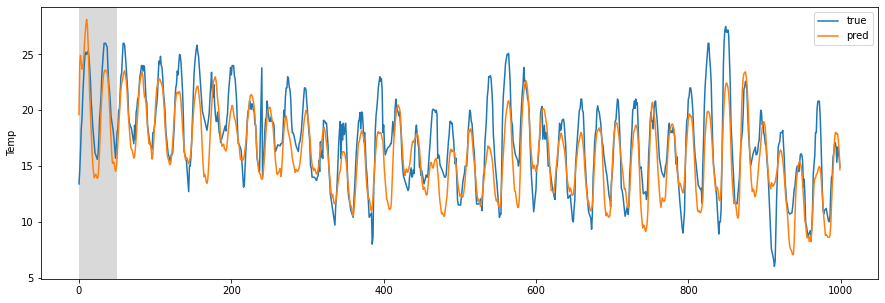

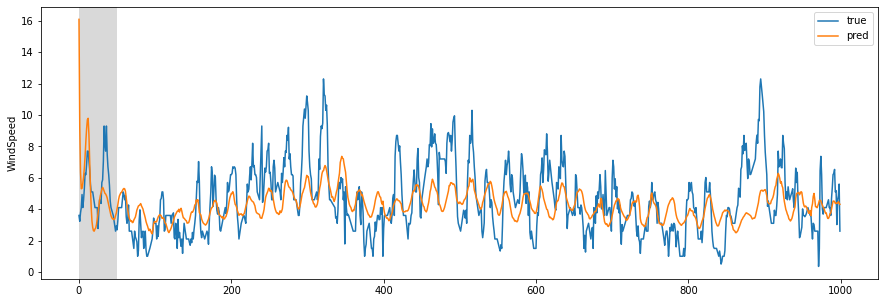

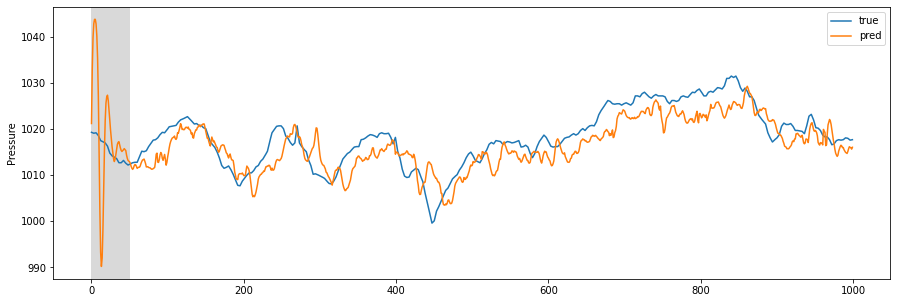

In [92]:
plot_comparison(start_idx=100000, length=1000, train=True)

El modelo fue capaz de predecir las oscilaciones globales de la temperatura bastante bien, pero los picos fueron a veces inexactos. En cuanto a la velocidad del viento, las oscilaciones generales se han predicho razonablemente bien, pero los picos son bastante inexactos. En cuanto a la presión atmosférica, se ha predicho la forma general de la curva, aunque parece haber un ligero retraso y la curva predicha tiene mucho ruido en comparación con la suavidad de la señal original.

### Ejemplo del conjunto de pruebas

Consideremos ahora un ejemplo del conjunto de pruebas. El modelo no ha visto estos datos durante el entrenamiento.

La temperatura se predice razonablemente bien, aunque los picos son a veces inexactos.

La velocidad del viento no se ha predicho tan bien. La frecuencia de oscilación diaria parece coincidir, pero el nivel central y los picos son bastante imprecisos. Una suposición sería que la velocidad del viento es difícil de predecir a partir de los datos de entrada dados, por lo que el modelo simplemente ha aprendido a producir oscilaciones sinusoidales en la frecuencia diaria y aproximadamente en el nivel central correcto.

La presión atmosférica se predice razonablemente bien, salvo por un retraso y una señal más ruidosa que la serie temporal real.

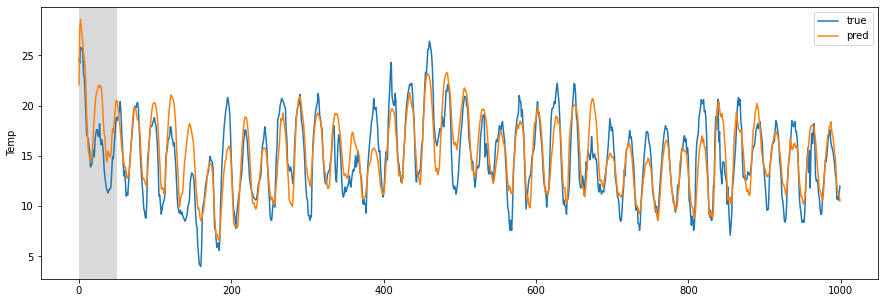

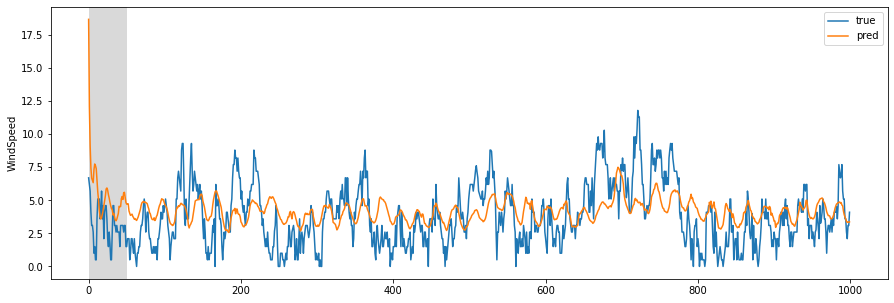

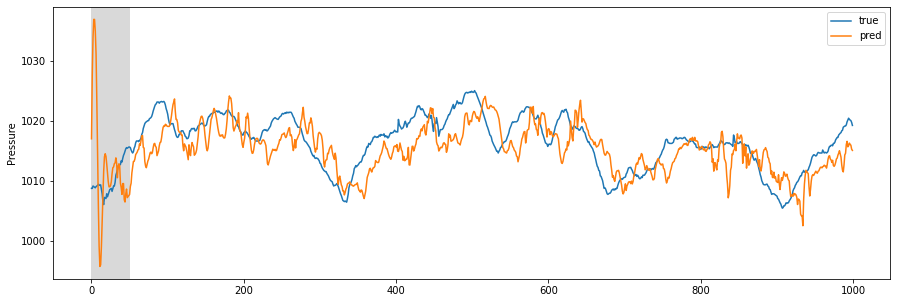

In [93]:
plot_comparison(start_idx=200, length=1000, train=False)

## Conclusión

En este ejercicio se ha mostrado cómo utilizar una Red Neuronal Recurrente para predecir varias series temporales a partir de una serie de señales de entrada. Hemos utilizado datos meteorológicos de 5 ciudades para predecir el tiempo de mañana en una de ellas.

Funcionó razonablemente bien en la predicción de la temperatura, donde las oscilaciones diarias se predijeron bien, pero los picos a veces no se predijeron con tanta precisión. La presión atmosférica también se predijo razonablemente bien, aunque la señal predicha era más ruidosa y tenía un corto retraso. La velocidad del viento no se pudo predecir muy bien.

Puedes utilizar este método con diferentes series temporales, pero debes tener cuidado de distinguir entre *causalidad y correlación* en los datos. La red neuronal puede descubrir fácilmente patrones en los datos que son sólo correlaciones temporales que no se generalizan bien a los datos no vistos.

Debe seleccionar datos de entrada y salida en los que probablemente exista una relación *causal*. Debe tener muchos datos disponibles para el entrenamiento, y debe intentar reducir el riesgo de sobreajuste del modelo a los datos de entrenamiento, por ejemplo, utilizando la parada temprana como hicimos en este tutorial.

## Ejercicios

Estas son algunas sugerencias sobre el problema estudiado

* Eliminar la velocidad del viento de los datos de destino. ¿Mejora la predicción de la temperatura y la presión?
* Entrene durante más épocas, posiblemente con una tasa de aprendizaje más baja. ¿Mejora el rendimiento en el conjunto de pruebas?
* Pruebe una arquitectura diferente para la red neuronal, por ejemplo, un tamaño de estado mayor o menor para la capa GRU, más capas GRU, capas densas antes y después de las capas GRU, etc.
* Utilice la optimización de hiperparámetros del tutorial 19.
* Pruebe a utilizar secuencias más largas y más cortas para el generador de lotes.
* Intente eliminar la ciudad "Odense" de las señales de entrada.
* Intente añadir los datos meteorológicos del año pasado a las señales de entrada.
* ¿Cómo de bueno es el modelo a la hora de predecir el tiempo a 3 o 7 días vista?
* ¿Puedes entrenar un único modelo con las señales de salida para múltiples turnos de tiempo, de forma que un único modelo prediga el tiempo en, por ejemplo, 1, 3 y 7 días?


## Referencias

* Documento inspirado en los cuadernos del MIT Copyright (c) 2018 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)
* Reconocimiento tambien a Alison Darcy y al equipo de Woebot por el asesoramiento en la creación de esta tarea:  http://woebot.io
* Doc oficial Pytorch https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
* https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

## Fin del cuaderno